In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, date, timezone, timedelta

# Jupyterの表示オプション
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# エクセルファイルの読み込み
# SIS日刊データ
SIS_df=pd.read_excel("Introduced\SIS分析プロジェクト_日刊60日切り-週間100データ対応_容量削減ver_200916.xlsm",
                     sheet_name="週間データ累積",
                     header=1,
                     encoding="cp932",
                     na_values=["データなし","-","###"])
SIS_df_droped=SIS_df.dropna(subset=["機種名","客滞","何週目"])
# 機種名の両端の空白削除、海のデータも除外
SIS_df_droped['機種名']=SIS_df_droped['機種名'].str.strip()
SIS_df_droped=SIS_df_droped[~SIS_df_droped['機種名'].str.contains("海物語")]
# 謎の小数があるため丸めて整数値に型変換
SIS_df_droped=SIS_df_droped.round({"何週目": 0}).astype({"何週目": int})
# 週間アウトの年月日データを記載
SIS_df_droped["年月日"]=SIS_df_droped["導入週"]+timedelta(weeks=SIS_df_droped["何週目"])-timedelta(days=1)
# SIS_df_droped=SIS_df_droped[(SIS_df_droped["客滞"] <= 200)]

# 市場スペックデータ
Spec_df=pd.read_excel("Introduced\右打ちチェック用市場データ改β.xlsm",
                      sheet_name="データベース",                      
                      encoding="cp932")
df_renamed=Spec_df.rename(columns={"Product_name":"機種名",
                                   "Oneshot_Rate":"単発率",
                                   "SurfaceCont_Rate":"名目継続率",
                                   "HeavenRush_Rate":"天国突入率",
                                   "HeavenTY_Ave":"天国TY平均",
                                   "FirtstT1Y_Ave":"初回平均T1Y",
                                   "GuessSimMY_Ave":"平均MY"})
# 継続率をビン分割
Cont_bins = [0,0.5,0.6,0.7,0.8,0.9,1]
TS_bins = [0,70,150,220,270,320]
Contbins_names=["継続0%-50%","継続50%-60%","継続60%-70%","継続70%-80%","継続80%-90%","継続90%-100%"]
TSbins_names=["甘未満","甘デジ","ライトミドル","ミドル","ハイミドル"]
# dfにビンの列を追加
df_renamed["継続率帯"] = pd.cut(df_renamed["名目継続率"], Cont_bins, labels=Contbins_names)
df_renamed["TS帯"] = pd.cut(df_renamed["TS"], TS_bins, labels=TSbins_names)

# 過去機種データベース
Product_df=pd.read_excel("Introduced\過去機種データベースまとめ_200617.xlsx",
                         sheet_name="オール機種 数値化",
                         header=11,
                         encoding="cp932")

C:\Users\k-furuhashi.SANSEI-RD\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: unsupported type for timedelta weeks component: Series

TS帯,甘未満,甘デジ,ライトミドル,ミドル,ハイミドル
1,1256.875,1046.011561,1977.000000,1688.611111,5417.875000
2,1382.500,1240.903614,2355.000000,1972.972973,6389.038462
3,1536.250,1325.581395,2341.149425,2173.783784,6683.937500
4,1508.750,1314.611111,2368.977273,2160.540541,6630.797546
5,1461.875,1309.780220,2354.606742,2067.368421,6466.626506
...,...,...,...,...,...
282,NaN,NaN,NaN,NaN,NaN
283,NaN,NaN,480.000000,NaN,NaN
284,NaN,NaN,540.000000,NaN,NaN
285,NaN,NaN,1290.000000,NaN,NaN


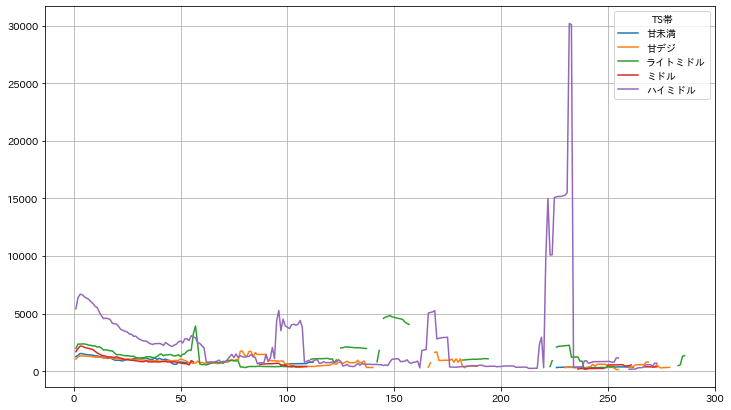

In [66]:
# アウトでピボット
pivot_SIS_df=SIS_df_droped.pivot_table(index="機種名", 
                                       columns="何週目",
                                       values="台数",
                                       aggfunc="sum")                          
# 対象となる日付をリスト化して保持
weeknum_list=list(pivot_SIS_df.columns)
# データフレームの結合
merge_df=pd.merge(left=pivot_SIS_df,
                  right=df_renamed,
                  left_index=True,
                  right_on="機種名",
                  how="left")
# 頭文字でP機のみにマスク
grouped=merge_df.groupby("TS帯").mean()[weeknum_list].T
grouped.plot(figsize=(12,7),grid=True)
grouped

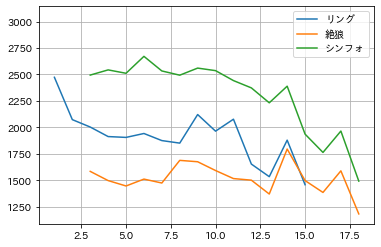

In [67]:
# 客滞でピボット
SIS_df_droped=SIS_df_droped.set_index("導入週")["2016-01-01":].reset_index()
pivot_SIS_df=SIS_df_droped.pivot_table(index="機種名", 
                                       columns="何週目",
                                       values="アウト",
                                       aggfunc="mean")
# 対象となる日付をリスト化して保持
date_list=list(pivot_SIS_df.columns)
# データフレームの結合
merge_df=pd.merge(left=pivot_SIS_df,
                  right=df_renamed,
                  left_index=True,
                  right_on="機種名",
                  how="left")
# groupe=merge_df.groupby("TS帯").mean()[date_list].T[0:50]
# plt.plot(merge_df[merge_df["機種名"]=="Pぱちんこウルトラ６兄弟K3"][date_list].T[0:],label="6兄弟")
# plt.plot(merge_df[merge_df["機種名"]=="Pひぐらしのなく頃に～廻～AM"][date_list].T[0:],label="ひぐらし廻")
# plt.plot(merge_df[merge_df["機種名"]=="P花の慶次～蓮L16-V"][date_list].T[0:60],label="慶次蓮")
# plt.plot(merge_df[merge_df["機種名"]=="Pひぐらしのなく頃に～憩～AZ"][date_list].T[0:60],label="ひぐらし甘")
# plt.plot(merge_df[merge_df["機種名"]=="PAF.バイオハザード２ Y"][date_list].T[0:60],label="バイオ甘")
# plt.plot(merge_df[merge_df["機種名"]=="PAぱちんこ新必殺仕置人TURBO-A8"][date_list].T[0:60],label="仕置人甘")
# plt.plot(merge_df[merge_df["機種名"]=="PAF.アクエリオン６ bY"][date_list].T[0:60],label="アクエリ甘")
# plt.plot(merge_df[merge_df["機種名"]=="PAぱちんこウルトラセブン２ A6"][date_list].T[0:60],label="ウルトラ甘")
# plt.plot(merge_df[merge_df["機種名"]=="PエウレカセブンハイエボゼロSEJD"][date_list].T[0:],label="エウレカ")
# plt.plot(merge_df[merge_df["機種名"]=="PモモキュンソードMC"][date_list].T[0:],label="モモキュン")
# plt.plot(merge_df[merge_df["機種名"]=="P義風堂々！！～兼続と慶次～２ M6-X"][date_list].T[0:],label="義風")
# plt.plot(merge_df[merge_df["機種名"]=="CRF.戦姫絶唱シンフォギア"][date_list].T[0:60],label="初代シンフォ")
# plt.plot(merge_df[merge_df["機種名"]=="Pぱちんこ仮面ライダー轟音M6"][date_list].T[0:60],label="轟音")
plt.plot(merge_df[merge_df["機種名"]=="Pリング　呪いの７日間２ JN"][date_list].T[0:],label="リング")
plt.plot(merge_df[merge_df["機種名"]=="P １０カウントチャージ絶狼MC"][date_list].T[0:],label="絶狼")
plt.plot(merge_df[merge_df["機種名"]=="PF.戦姫絶唱シンフォギア２"][date_list].T[0:],label="シンフォ")
# plt.plot(merge_df[merge_df["機種名"]=="P大工の源さん超韋駄天YTA"][date_list].T[0:],label="源さん")
# plt.plot(merge_df[merge_df["機種名"]=="PA真・怪獣王ゴジラNL-K1"][date_list].T[0:60],label="ゴジラ77")

plt.grid()
plt.legend()
# groupe.plot(figsize=(10,6),grid=True,title="導入日数毎客滞推移")

In [62]:
SIS_df_droped["導入週"]
pd.to_datetime(SIS_df_droped["導入週"])
SIS_df_droped["導入週"]

0       2016-03-21
1       2016-03-21
2       2016-03-21
3       2016-03-21
4       2016-03-21
           ...    
24845   2015-10-19
24846   2015-10-19
24847   2015-10-05
24848   2015-08-17
24849   2015-08-17
Name: 導入週, Length: 23232, dtype: datetime64[ns]